# 高维线性回归数据集 
我们使用上一节相同的高维线性回归为例来引入一个过拟合问题 

In [1]:
from mxnet import ndarray as nd 
from mxnet import autograd 
from mxnet import gluon 

In [3]:
num_train=20 
num_test=100
num_inputs=200 

true_w=nd.ones((num_inputs,1))*0.01 
true_b=0.05 

X=nd.random.normal(shape=(num_train+num_test,num_inputs)) 
y=nd.dot(X,true_w) 
y+=0.01*nd.random.normal(shape=y.shape)

X_train,X_test=X[:num_train,:],X[num_train:,:]
y_train,y_test=y[:num_train,:],y[num_train:,:]

# 定义训练和测试 
跟之前一样的定义训练模块。你也许发现了主要区别，Trainer有一个新参数wd.
我们通过优化算法的wd 参数（weight decay)实现对模型的正则化。这相当于L2范数正则化。 

In [4]:
%matplotlib inline 
import matplotlib as mpl 
mpl.rcParams['figure.dpi']=120 
import matplotlib.pyplot as plt 

In [5]:
batch_size=1 
dataset_train=gluon.data.ArrayDataset(X_train,y_train) 
data_iter_train=gluon.data.DataLoader(dataset_train,batch_size,shuffle=True)

square_loss=gluon.loss.L2Loss() 

In [7]:
def test(net,X,y):
    return square_loss(net(X),y).mean().asscalar() 

def train(weight_decay):
    learning_rate=0.005
    epochs=10 
    net=gluon.nn.Sequential() 
    with net.name_scope():
        net.add(gluon.nn.Dense(1))
    net.initialize() 
    # 注意这里'wd' 
    trainer=gluon.Trainer(net.collect_params(),'sgd',{'learning_rate':learning_rate,'wd':weight_decay})
    # w = w - lr * grad - wd * w 
    train_loss=[]
    test_loss=[] 
    for e in range(epochs):
        for data,label in data_iter_train:
            with autograd.record():
                output=net(data)
                loss=square_loss(output,label)
            loss.backward()
            trainer.step(batch_size) 
        train_loss.append(test(net,X_train,y_train))
        test_loss.append(test(net,X_test,y_test)) 
    plt.plot(train_loss)
    plt.plot(test_loss) 
    plt.legend(['train','test']) 
    plt.show()
    return ('learned w[:10]:',net[0].weight.data()[:,:10],'leanred b :',net[0].bias.data() )

## 训练模型并观察过拟合 
接下来我们训练并测试我们的高维线性回归模型 。

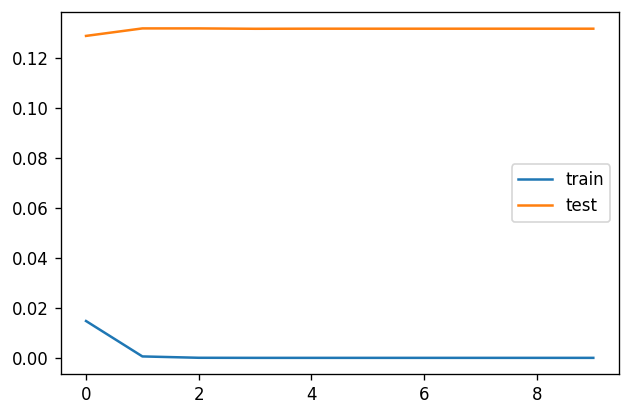

('learned w[:10]:',
 
 [[ 0.00807388 -0.02511347 -0.02147206 -0.06466364 -0.0426905   0.06303062
    0.03779016 -0.01668471 -0.01527443 -0.00334097]]
 <NDArray 1x10 @cpu(0)>,
 'leanred b :',
 
 [0.01496702]
 <NDArray 1 @cpu(0)>)

In [8]:
train(0)

即使训练误差可以达到0.00000,但是测试数据集上的误差很高。这是典型的过拟合现象。
观察学习的参数。事实上，大部分学到的参数的绝对值比真实参数的绝对值要大一些。 

# 使用 Gluon的正则化 
下面我们重新初始化模型参数并在Trainer里设置一个wd参数 

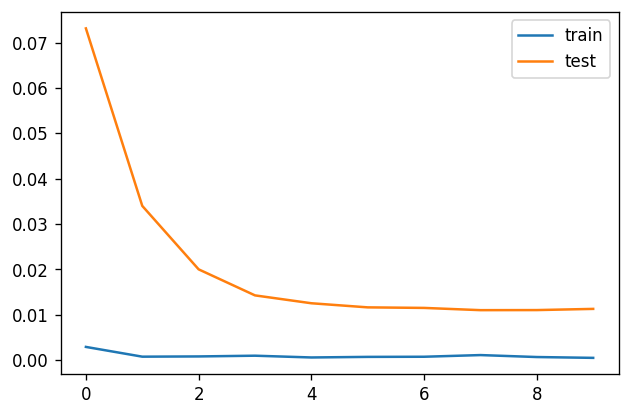

('learned w[:10]:',
 
 [[ 0.0042342   0.00383433  0.00187826  0.00293594 -0.00195989  0.00133184
    0.00177917 -0.0015012   0.00159238  0.00333033]]
 <NDArray 1x10 @cpu(0)>,
 'leanred b :',
 
 [0.00656311]
 <NDArray 1 @cpu(0)>)

In [9]:
train(5) 